## Running hyperparameter optimization - Part 2

This notebook goes through part two of the steps and codes for identifying the optimal hyperparameter settings for the Variational Autoencoder framework for integrating multi-omics and clinical data spanning both categorical and continuous variables. <br>

The optimal settings are identified based on multiple steps cosidering both reconstruction on the test and training sets as well as the stability/similiarity of the latent space in case of repeated training. Part one focus on the test and training reconstruction accuracies using in <i>MOVE_hyperparameter_optimization_reconstruction.ipynb</i>. From those results the optimal combination are then tested for stability of the latent space in repeated training using this notebook.

In [33]:
#!pip uninstall umap
!pip install umap-learn


ERROR: ld.so: object '/usr/local/lib/AppProtection/libAppProtection.so' from /etc/ld.so.preload cannot be preloaded (cannot open shared object file): ignored.
ERROR: ld.so: object '/usr/local/lib/AppProtection/libAppProtection.so' from /etc/ld.so.preload cannot be preloaded (cannot open shared object file): ignored.
ERROR: ld.so: object '/usr/local/lib/AppProtection/libAppProtection.so' from /etc/ld.so.preload cannot be preloaded (cannot open shared object file): ignored.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
ERROR: ld.so: object '/usr/local/lib/AppProtection/libAppProtection.so' from /etc/ld.so.preload cannot be preloaded (cannot open shared object file): ignored.
You should consider upgrading via the '/snap/jupyter/6/bin/python -m pip install --upgrade pip' command.


In [34]:
# Import functions
import os, sys
import torch
import numpy as np
from torch.utils import data

from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import TensorDataset

# import umap
import umap.umap_ as umap

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from scipy.stats.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import pandas as pd
import seaborn as sns
import matplotlib
import re
import random
from collections import defaultdict
import itertools 
# import tqdm   


path="./"
sys.path.append(path + "src/")
import VAE_v2_1

from utils.data_utils import *

Below are the funcitons for reading data and calculations defiend

In [35]:
# Functions for calculations
def cal_cat_recon(cat_shapes, cat_recon, cat_class):
   cat_true_recon = []
   cat_total_recon = []
   pos = 0
   for s in cat_shapes:
      n = s[1]
      cat_class_tmp = cat_class[:,pos:(n + pos)]
      cat_recon_tmp = cat_recon[:,pos:(n + pos)]
      
      missing_cat = cat_recon_tmp[cat_class_tmp == -1]
      diff_cat = cat_class_tmp - cat_recon_tmp
      
      diff_cat[diff_cat != 0] = -1
      true_cat = diff_cat[diff_cat == 0]
      false_cat = diff_cat[diff_cat != 0]
      cat_true = len(true_cat)/(float(diff_cat.size) - missing_cat.size)
      cat_true_recon.append(cat_true)
      diff_cat[diff_cat == 0] = 1
      diff_cat[diff_cat != 1] = 0
      cat_total_recon.append(np.count_nonzero(diff_cat, 1) / diff_cat.shape[1])
      pos += n
   return cat_total_recon

def cal_con_recon(train_loader, con_recon, con_shapes):
   total_shape = 0
   true_recon = []
   cos_values = []
   all_values = []
   for s in con_shapes:
      cor_con = list()
      cos_con = list()
      all_val =list()
      for n in range(0, con_recon.shape[0]):
         con_no_missing = train_loader.dataset.con_all[n,total_shape:(s + total_shape - 1)][train_loader.dataset.con_all[n,total_shape:(s + total_shape - 1)] != 0]
         if len(con_no_missing) <= 1:
            all_val.append(np.nan)
            continue
         con_out_no_missing = con_recon[n,total_shape:(s + total_shape - 1)][train_loader.dataset.con_all[n,total_shape:(s + total_shape - 1)] != 0]
         cor = pearsonr(con_no_missing, con_out_no_missing)[0]
         cor_con.append(cor)
         
         com = np.vstack([con_no_missing, con_out_no_missing])
         cos = cosine_similarity(com)[0,1]
         cos_con.append(cos)
         all_val.append(cos)
      
      cor_con = np.array(cor_con)
      cos_con = np.array(cos_con)
      cos_values.append(cos_con)
      all_values.append(np.array(all_val))
      true_recon.append(len(cos_con[cos_con >= 0.7]) / len(cos_con))
      total_shape += s
      
   return true_recon

The next part is for reading in the data. This example uses the different datatypes included in the publication of MOVE which consist of three categorical datatypes and seven continuous. NOTE the data is not availble for testing. 

In [36]:
path = './'

In [37]:
def draw_boxplot(df, title_text, y_label_text, save_fig_name):
    
    df = pd.DataFrame(df)
    fig = plt.figure(figsize=(18,14))
    ax = sns.boxplot(data=df, palette = sns.color_palette('colorblind', df.shape[1]))
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45, size=16, horizontalalignment='right')
    plt.title(title_text, size=20)
    plt.ylabel(y_label_text, size=16)
    plt.xlabel('')
    plt.yticks(fontsize=16)
    plt.savefig(path + f"hyperparameters/{save_fig_name}.png")

For this part we use all the data contraty to part 1 where it was divided into trainig and test, and investigate how similar the latent space is between the repeated runs. Below we define the selected hyper-parameter settings with equal or close to equal performance based on part 1. For plotting purposes we only test on three different "types" here being size of the hidden layer (nHidden), size of the latent space (nLatents) and the drop-out (drop_outs). The number of hidden lasyers are set to 1 (nl=1). We here repeat the traininng 5 times. 

In [38]:
# If using GPU set to TRUE
cuda = False #cuda = True

# nHiddens = [1000, 2000]
# nLatents = [50, 100, 200]
# drop_outs = [0.1, 0.3]
# repeat = 5

nHiddens = [1000, 2000]
nLatents = [50, 100, 200]
drop_outs = [0.1, 0.3]
repeat = 2


nepochs = 2  #nepochs = 250
nl = 1
lrate=1e-3 #Added
kldsteps=[20, 30, 40, 90] #Added
batchsteps=[50, 100, 150, 200, 250, 300, 350, 400, 450] #Added

In [39]:
data_dict = read_yaml('data')
cat_list, con_list, cat_names, con_names, headers_all, drug, drug_h = get_data(data_dict)

params_dict = read_yaml('02_tune_reconstruction')

cuda = params_dict['cuda']
path = params_dict['path']
nHiddens = params_dict['nHiddens']
nLatents = params_dict['nLatents']
nLayers = params_dict['nLayers']
nDropout = params_dict['nDropout']
nBeta = params_dict['nBeta']
batch_sizes = params_dict['batch_sizes']
nepochs = params_dict['nepochs']
lrate = float(params_dict['lrate'])
repeat = params_dict['repeat']
patience = params_dict['patience']


Below we run the full grid search. Here we also save the UMAP embeddings for the posibility of a visual investigation of the results.

In [40]:
# By cosine similirity. 
def optimize_stability(nHiddens, nLatents, drop_outs, repeat, nepochs, nl, lrate, kldsteps, batchsteps, cuda, path, con_list, cat_list):
    
   device = torch.device("cuda" if cuda == True else "cpu") #TODO: repeat is not included anywhere, I think
   models, latents, embeddings, con_recons, cat_recons, recon_acc, los, likelihood = initiate_default_dicts(1, 7)
    
   iters = itertools.product(nHiddens, nLatents, drop_outs, range(repeat))
   for nHidden, nLatent, do, r in iters:
      combi = str([nHidden] * nl) + "+" + str(nLatent) + ", Drop-out:" + str(do)
      print(combi)

      mask, train_loader = VAE_v2_1.make_dataloader(cat_list=cat_list, con_list=con_list, batchsize=10)

      ncategorical = train_loader.dataset.cat_all.shape[1]
      ncontinuous = train_loader.dataset.con_all.shape[1]
      con_shapes = train_loader.dataset.con_shapes
      cat_shapes = train_loader.dataset.cat_shapes

      model = VAE_v2_1.VAE(ncategorical=ncategorical, ncontinuous= ncontinuous,
                        con_shapes=con_shapes, cat_shapes=cat_shapes, nhiddens=[nHidden]*nl,
                        nlatent=nLatent,  beta=0.0001, con_weights=[1,1,1,1,1,1,1],
                        cat_weights=[1,1,1], dropout=do, cuda=cuda).to(device) #alpha=0.1, 

      loss = list(); ce = list(); sse = list(); KLD = list()
      
      kld_w = 0
      l = len(kldsteps)
      rate = 20/l 
      update = 1
    
      for epoch in range(1, nepochs + 1):

         if epoch in kldsteps:
            kld_w = 1/20 * update
            update += rate

         if epoch in batchsteps:
                  train_loader = DataLoader(dataset=train_loader.dataset,
                                          batch_size=int(train_loader.batch_size * 1.25), 
                                          shuffle=True,
                                          drop_last=True,
                                          num_workers=train_loader.num_workers,
                                          pin_memory=train_loader.pin_memory)
                
         l, c, s, k = model.encoding(train_loader, epoch, lrate, kld_w)
        
         loss.append(l)
         ce.append(c)
         sse.append(s)
         KLD.append(k)

      test_loader = DataLoader(dataset=train_loader.dataset, batch_size=1, drop_last=False,
                     shuffle=False, pin_memory=train_loader.pin_memory) #num_workers=1,

      latent, latent_var, cat_recon, cat_class, con_recon, test_loss, test_likelihood = model.latent(test_loader, kld_w)
      con_recon = np.array(con_recon)
      con_recon = torch.from_numpy(con_recon)

      cat_true_recon = cal_cat_recon(cat_shapes, cat_recon, cat_class)
      true_recon = cal_con_recon(train_loader, con_recon, con_shapes)

      ### Umap clustering 
      reducer = umap.UMAP()
      embedding = reducer.fit_transform(latent)

      # save
      recon_acc[combi].append(cat_true_recon + true_recon)
      latents[combi].append(latent)
      embeddings[combi].append(embedding)
      con_recons[combi].append(con_recon)
      cat_recons[combi].append(cat_recon)

   # Saving the results
   np.save(path + "hyperparameters/embedding_stab.npy", embeddings)
   np.save(path + "hyperparameters/latent_stab.npy", latents)
   np.save(path + "hyperparameters/con_recon_stab.npy", con_recons)
   np.save(path + "hyperparameters/cat_recon_stab.npy", cat_recons)
   np.save(path + "hyperparameters/recon_acc_stab.npy", recon_acc)
   
   return(embeddings, latents, con_recons, cat_recons, recon_acc)

embeddings, latents, con_recons, cat_recons, recon_acc = optimize_stability(nHiddens, nLatents, 
                                                                            drop_outs, repeat,
                                                                            nepochs, nl,
                                                                            lrate, kldsteps,
                                                                            batchsteps, cuda, 
                                                                            path, con_list, cat_list)


[500]+20, Drop-out:0.1
	Epoch: 1	Loss: 11.909726	CE: 3.6536606	SSE: 8.256065	KLD: 0.0000	Batchsize: 10
	Epoch: 2	Loss: 11.446306	CE: 3.5847301	SSE: 7.861576	KLD: 0.0000	Batchsize: 10
====> Test set loss: 189.0270
[500]+20, Drop-out:0.1
	Epoch: 1	Loss: 11.893165	CE: 3.6457343	SSE: 8.247431	KLD: 0.0000	Batchsize: 10
	Epoch: 2	Loss: 11.445494	CE: 3.5870001	SSE: 7.858494	KLD: 0.0000	Batchsize: 10
====> Test set loss: 970.1205
[500]+20, Drop-out:0.3
	Epoch: 1	Loss: 12.165091	CE: 3.6674962	SSE: 8.497595	KLD: 0.0000	Batchsize: 10
	Epoch: 2	Loss: 11.645940	CE: 3.6125586	SSE: 8.033381	KLD: 0.0000	Batchsize: 10
====> Test set loss: 219805.8489
[500]+20, Drop-out:0.3
	Epoch: 1	Loss: 12.172846	CE: 3.6670414	SSE: 8.505804	KLD: 0.0000	Batchsize: 10
	Epoch: 2	Loss: 11.637317	CE: 3.6047783	SSE: 8.032538	KLD: 0.0000	Batchsize: 10
====> Test set loss: 6783.0687
[500]+50, Drop-out:0.1
	Epoch: 1	Loss: 12.061272	CE: 3.6601433	SSE: 8.401128	KLD: 0.0000	Batchsize: 10
	Epoch: 2	Loss: 11.399069	CE: 3.5676310	S

In [41]:
# Run if you want to reload the results
embeddings = np.load(path + "hyperparameters/embedding_stab.npy", allow_pickle = True).item()
latents = np.load(path + "hyperparameters/latent_stab.npy", allow_pickle = True).item()
con_recons = np.load(path + "hyperparameters/con_recon_stab.npy", allow_pickle = True).item()
cat_recons = np.load(path + "hyperparameters/cat_recon_stab.npy", allow_pickle = True).item()
recon_acc = np.load(path + "hyperparameters/recon_acc_stab.npy", allow_pickle = True).item()

Below is calcualtion and visualisation only focusig on the top 10 closest neigbour for each individual

In [42]:
def get_top10_stability(nHiddens, nLatents, drop_outs, repeat, nl, latents):
   # Todo: TOP10 not used description by Rosa
   npatient = list(latents.values())[0][0].shape[0]
   top10_changes, stability_top10 = initiate_default_dicts(0, 2) #TODOS: top10 changes not needed? - mention, not used
    
   iters = itertools.product(nHiddens, nLatents, drop_outs)
   for nHidden, nLatent, do in iters: 
      max_pos_values_init = list()
      old_sum_max = list()

      name = str([nHidden] * nl) + "+" + str(nLatent) + ", Drop-out:" + str(do)
      print(name)
      top10_changes[name] = [ [] for i in range(npatient) ]
    
      for r in range(repeat):
         cos_sim = cosine_similarity(latents[name][r])
         corr = pd.DataFrame(cos_sim)
            
         step = list()
         for index, row in corr.iterrows():
            if r == 0:
               max_pos = np.asarray(row.argsort()[11:][::-1][1:11])
               max_pos_values_init.append(max_pos)
               #summed_max = np.mean(row[max_pos])
               old_sum_max.append(row[max_pos])
            else:
               old_pos = max_pos_values_init[index]
               old_sum = old_sum_max[index]
               #summed_max = np.mean(row[old_pos])
               top10_changes[name][index].append(np.mean(abs(old_sum - row[old_pos])))
               step.append(np.mean(abs(old_sum - row[old_pos])))
         print(r)
         if r != 0:
            stability_top10[name].append(np.mean(step))

   return(stability_top10)
stability_top10 = get_top10_stability(nHiddens, nLatents, drop_outs, repeat, nl, latents)

[500]+20, Drop-out:0.1
0
1
[500]+20, Drop-out:0.3
0
1
[500]+50, Drop-out:0.1
0
1
[500]+50, Drop-out:0.3
0
1
[1000]+20, Drop-out:0.1
0
1
[1000]+20, Drop-out:0.3
0
1
[1000]+50, Drop-out:0.1
0
1
[1000]+50, Drop-out:0.3
0
1


In [43]:
# print(cat.shape[0])
# print(list(latents.values())[0][0].shape[0])
print(stability_top10)

defaultdict(<class 'list'>, {'[500]+20, Drop-out:0.1': [0.6108086], '[500]+20, Drop-out:0.3': [0.58406794], '[500]+50, Drop-out:0.1': [0.44355923], '[500]+50, Drop-out:0.3': [0.4394825], '[1000]+20, Drop-out:0.1': [0.59798884], '[1000]+20, Drop-out:0.3': [0.57847023], '[1000]+50, Drop-out:0.1': [0.4158343], '[1000]+50, Drop-out:0.3': [0.41128892]})


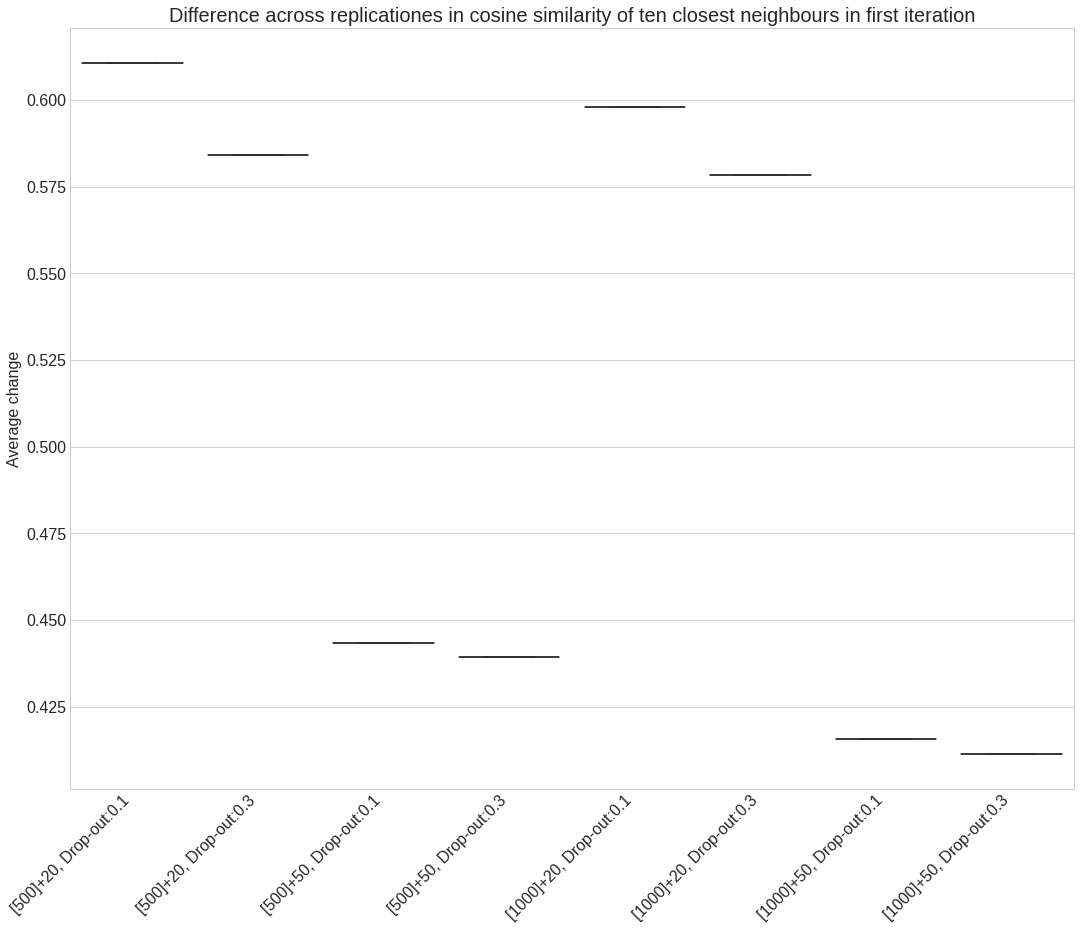

In [44]:
draw_boxplot(df=stability_top10,
             title_text='Difference across replicationes in cosine similarity of ten closest neighbours in first iteration',
             y_label_text="Average change",
             save_fig_name="stability_top10")

The next part compared based on all of the latent space. Furthermore, it includes code for calculation on cluster stability if the latent space is to be used for clustering (not used by MOVE in the paper here only cosine similarity on latent is included).

In [45]:
def calculate_latent(nHiddens, nLatents, drop_outs, repeat, latents):
#    npatient = cat.shape[0] # Change into smthg better
   npatient = list(latents.values())[0][0].shape[0]
   total_changes, stability_total, rand_index = initiate_default_dicts(0, 3)
    
   iters = itertools.product(nHiddens, nLatents, drop_outs)
   for nHidden, nLatent, do in iters:  
      pos_values_init = list() 
      old_rows = list()
        
      name = str([nHidden] * nl) + "+" + str(nLatent) + ", Drop-out:" + str(do)
      total_changes[name] = [ [] for i in range(npatient) ]

      for r in range(repeat):
         cos_sim = cosine_similarity(latents[name][r])

         corr = pd.DataFrame(cos_sim)
         step = list()
         for index, row in corr.iterrows():
            if r == 0:
               max_pos = np.asarray(row.argsort()[:][::-1][1:])
               pos_values_init.append(max_pos)
               old_rows.append(row[max_pos])
            else:
               old_pos = pos_values_init[index]
               old_row = old_rows[index]
               total_changes[name][index].append(np.mean(abs(old_row - row[old_pos])))
               step.append(np.mean(abs(old_row - row[old_pos])))

         if r != 0:
            kmeans = KMeans(n_clusters=4)
            rand_tmp = []
            for i in range(0,100):
               kmeans = kmeans.fit(latents[name][r])
               labels = kmeans.predict(latents[name][r])
               rand_tmp.append(adjusted_rand_score(true_labels, labels)) #Changed to adjusted_rand_score

            rand_index[name].append(np.mean(rand_tmp))
            stability_total[name].append(np.mean(step))
         else:
            kmeans = KMeans(n_clusters=4)
            kmeans = kmeans.fit(latents[name][r])
            true_labels = kmeans.predict(latents[name][r])

   stability_total = pd.DataFrame(stability_total)
   return(stability_total, rand_index)

stability_total, rand_index = calculate_latent(nHiddens, nLatents, drop_outs, repeat, latents)

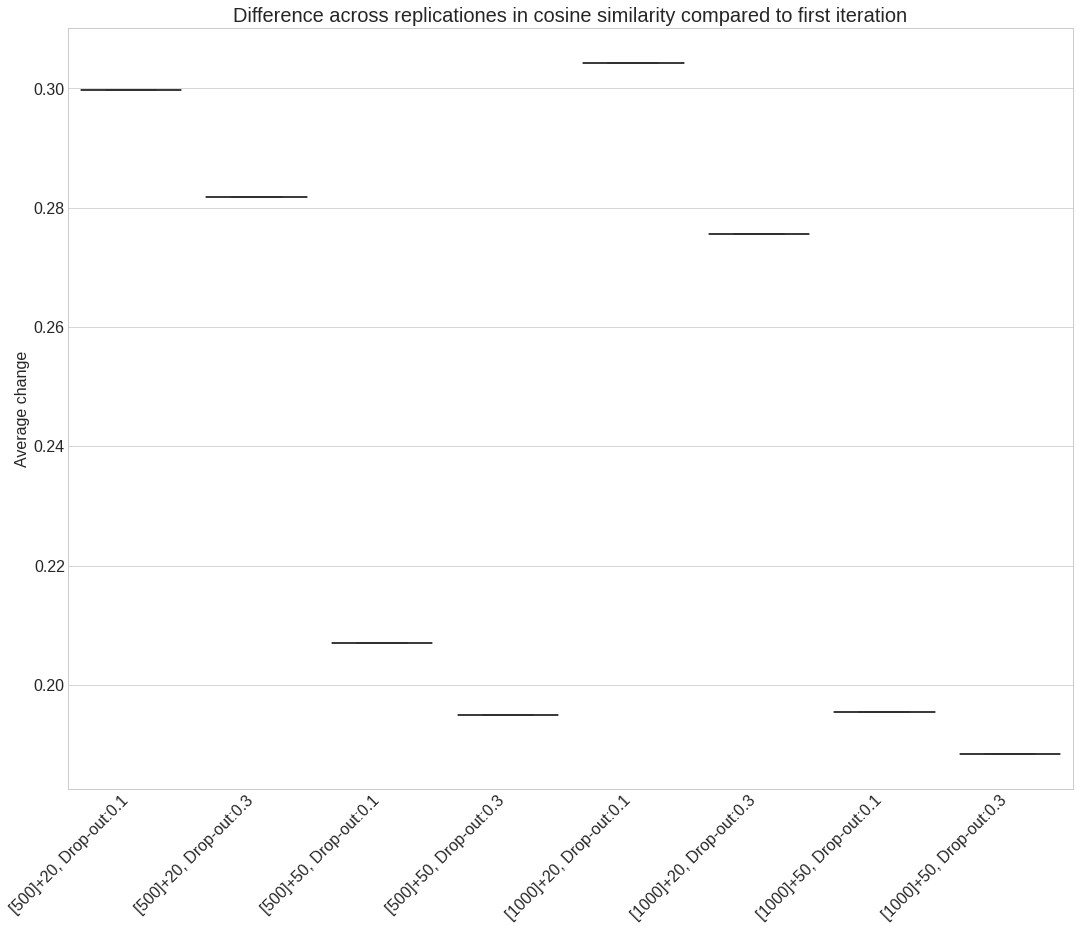

In [47]:
draw_boxplot(df=stability_total,
             title_text='Difference across replicationes in cosine similarity compared to first iteration',
             y_label_text="Average change",
             save_fig_name="stability_all")

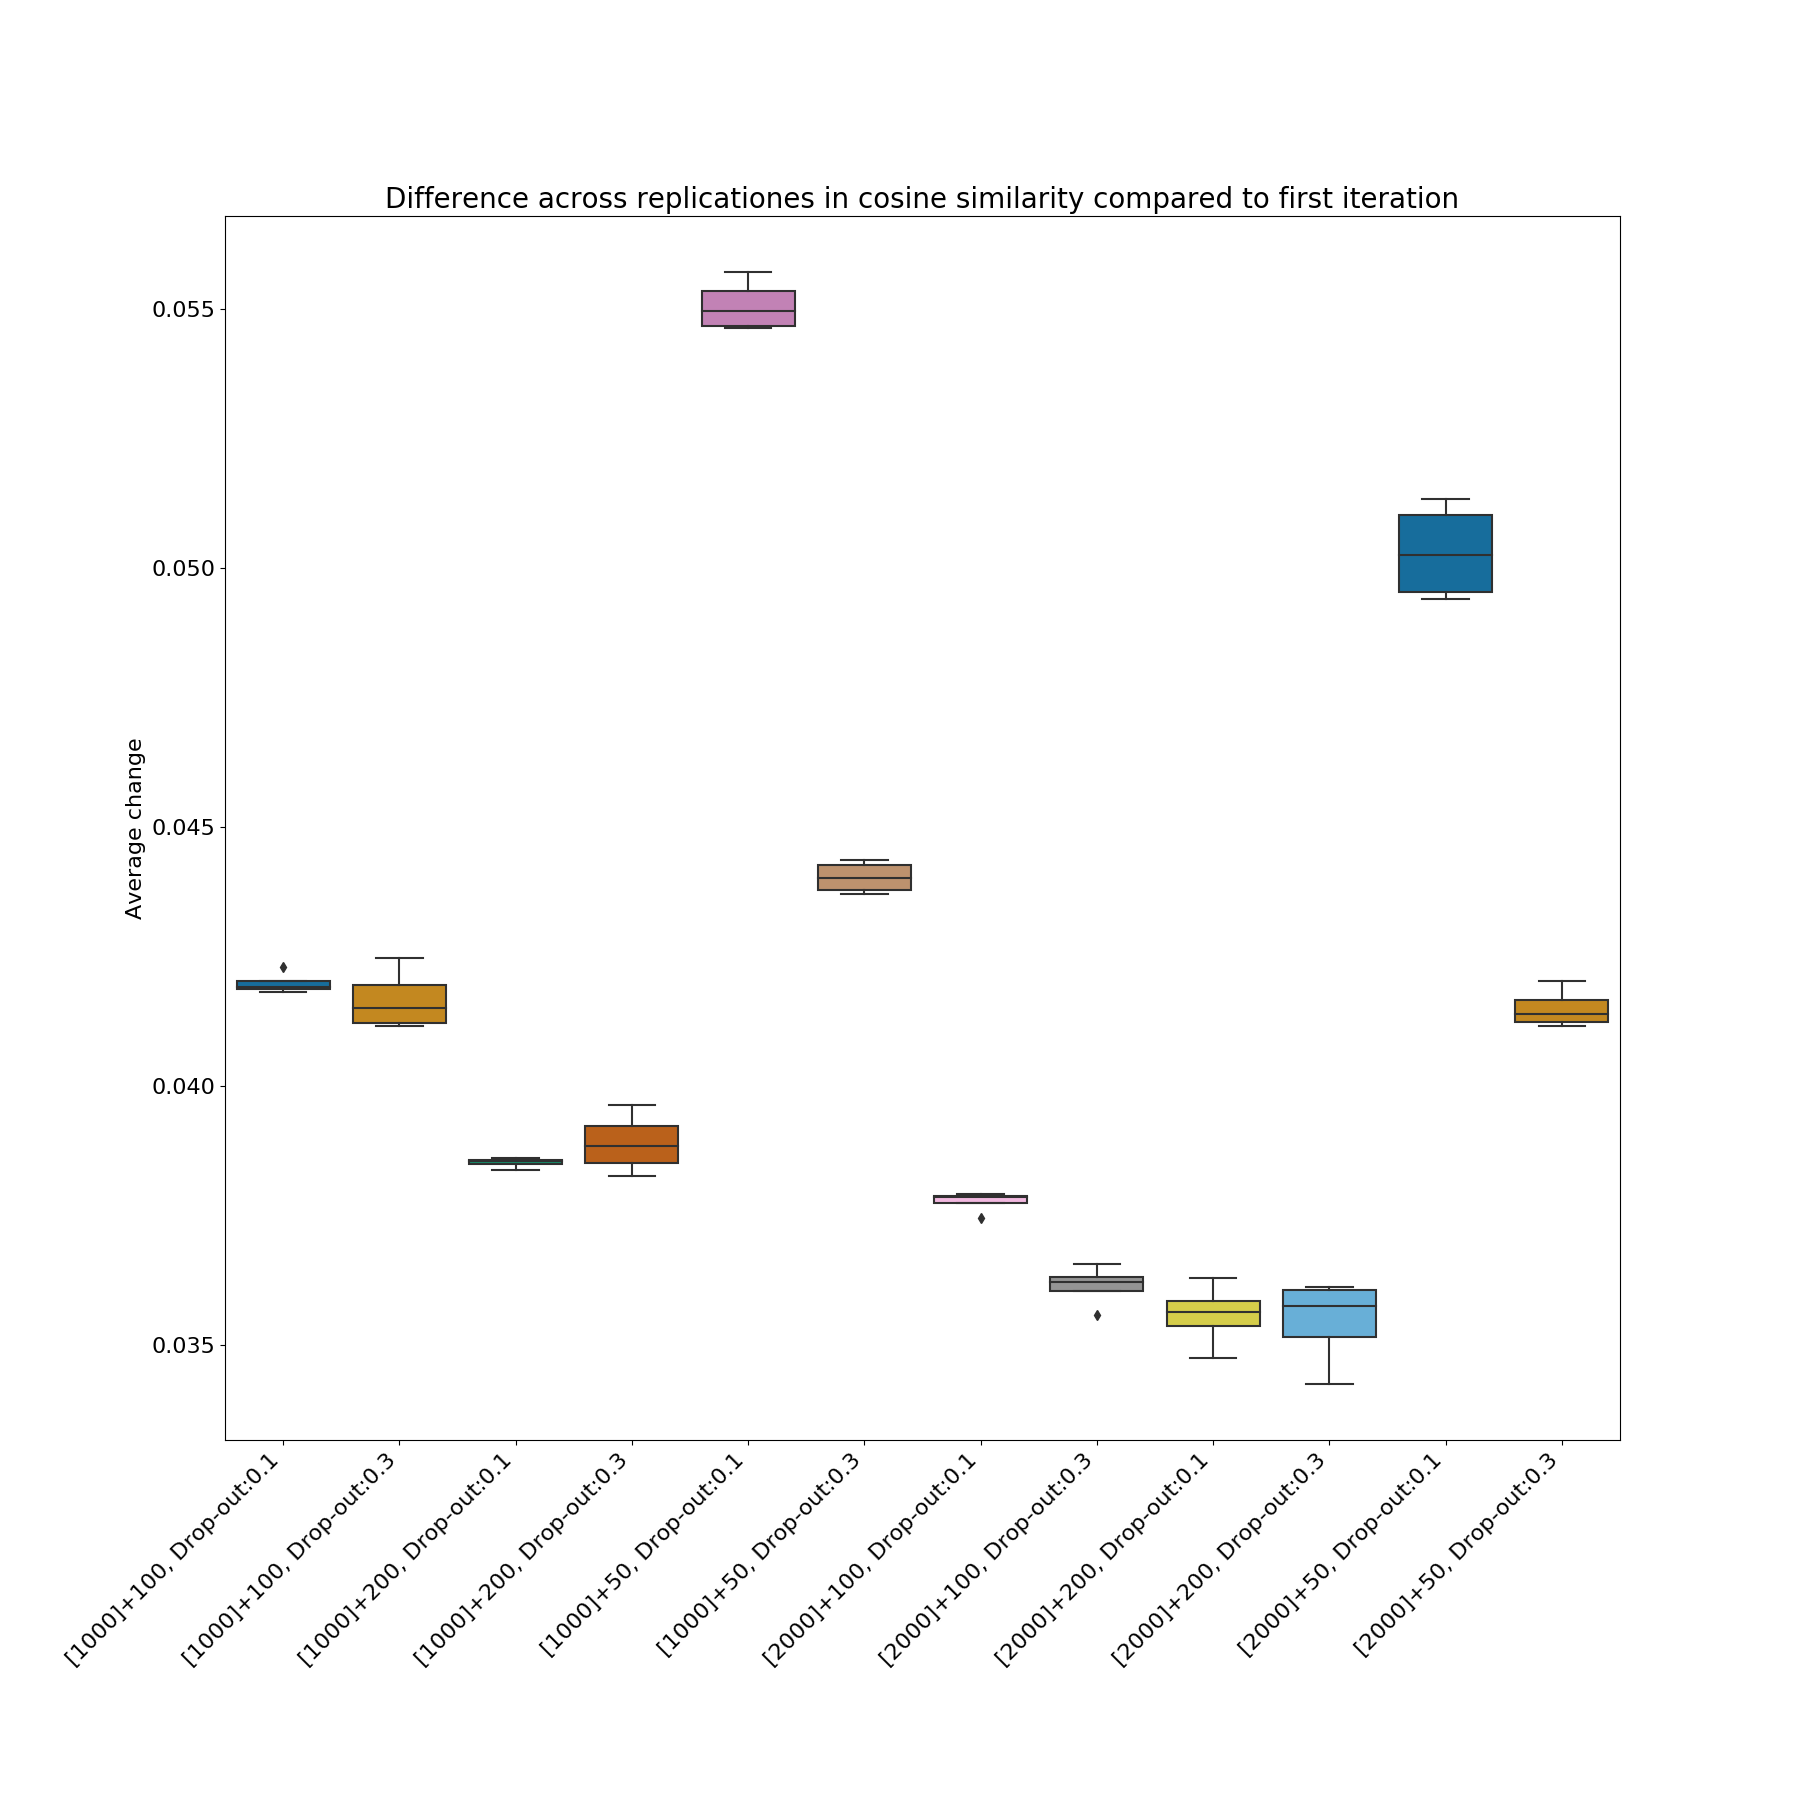

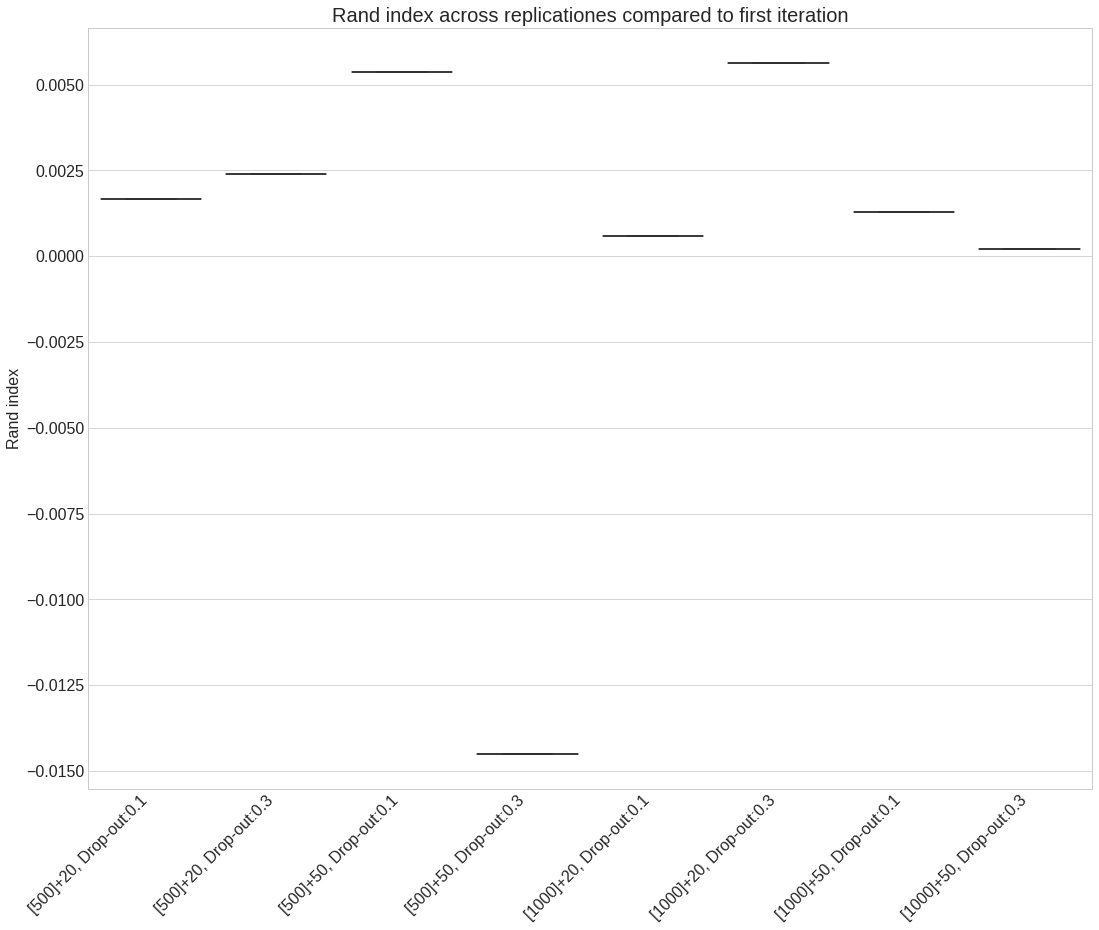

In [48]:
draw_boxplot(df=rand_index,
             title_text='Rand index across replicationes compared to first iteration',
             y_label_text="Rand index",
             save_fig_name="rand_index_all")

From here on the optimal setting for further analysis can be selected. This includes the framework used in MOVE for identifying drug and multi-omics assosiations as descriped in the notebook <i>identify_drug_assosiation.ipynb</i>, compare the latent space integration to other methods (PCA) using the notebook <i>latent_space_analysis.ipynb</i> or for other types of analysis such as clustering of the latent space (not included here). 